# 02 — DATASET LOADER FROM PostgreSQL

Questo notebook è la **procedura eseguibile** della pipeline dati del progetto.

1. Carica i metadati dal DB PostgreSQL (tabella `images`)
2. Crea gli split `df_train / df_val / df_test` sulla base di essi
3. Costruisce i dataset `tf.data` con preprocessing **on-the-fly** (resize-with-pad + normalizzazione)
4. Esegue check rapidi (shape, range pixel, visualizzazione)


> Nota: ogni notebook di training ricrea la pipeline

## 0) Setup import e path

A partire dai file:
- `src/garbagecls/db.py`
- `src/garbagecls/paths.py`
- `src/garbagecls/dataset.py`


In [1]:
import sys
from pathlib import Path

# Aggiunge la root della repo al PYTHONPATH così possiamo importare da /src
ROOT = Path.cwd().parent if Path.cwd().name.lower() == "notebooks" else Path.cwd()
sys.path.append(str(ROOT / "src"))

%load_ext autoreload
%autoreload 2


In [2]:
from garbagecls.db import load_env, read_images_df, split_dfs
from garbagecls.dataset import build_label_maps, make_dataset
from garbagecls.paths import PROJECT_ROOT, abs_path


## 1) Caricamento metadati dal DB


In [10]:
load_env()

# Leggiamo solo il dataset principale
df = read_images_df(source="raw_flat")

print("Totale righe:", len(df),'\n')
display(df.head())


Totale righe: 2527 



c:\Users\simon\Documents\VSC\Progetto-Data-Science\src\garbagecls\db.py:83: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(base_query, conn, params=params if params else None)


,image_id,filepath,label,split,width,height,channels,source
0,1,data/raw_flat/plastic/plastic92.jpg,plastic,train,512,384,3,raw_flat
1,2,data/raw_flat/cardboard/cardboard305.jpg,cardboard,train,512,384,3,raw_flat
2,3,data/raw_flat/cardboard/cardboard53.jpg,cardboard,train,512,384,3,raw_flat
3,4,data/raw_flat/cardboard/cardboard42.jpg,cardboard,train,512,384,3,raw_flat
4,5,data/raw_flat/metal/metal141.jpg,metal,train,512,384,3,raw_flat


### 1.1 Check split e distribuzione classi

In [14]:
print("Split counts:")
display(df["split"].value_counts())

print("\nLabel counts (top 10):")
display(df["label"].value_counts().head(10))

# Mostriamo per ogni split come sono suddivise le classi
for split_name in ["train", "val", "test"]:
    split_df = df[df["split"] == split_name]
    print(f"\n{split_name.upper()} - Label distribution (%):")
    label_pct = (split_df["label"].value_counts(normalize=True) * 100).round(2)
    display(label_pct)


Split counts:


split
train    1768
test      380
val       379
Name: count, dtype: int64


Label counts (top 10):


label
paper        594
glass        501
plastic      482
metal        410
cardboard    403
trash        137
Name: count, dtype: int64


TRAIN - Label distribution (%):


label
paper        23.53
glass        19.80
plastic      19.06
metal        16.23
cardboard    15.95
trash         5.43
Name: proportion, dtype: float64


VAL - Label distribution (%):


label
paper        23.48
glass        19.79
plastic      19.00
cardboard    16.09
metal        16.09
trash         5.54
Name: proportion, dtype: float64


TEST - Label distribution (%):


label
paper        23.42
glass        20.00
plastic      19.21
metal        16.32
cardboard    15.79
trash         5.26
Name: proportion, dtype: float64

Le classi sono distribuite equamente su tutti i 3 split mantenendo le proporzioni

## 2) Costruzione split DataFrame + encoding label


- `label_id` è un intero in `[0, K-1]` utile per `SparseCategoricalCrossentropy`.
- Esempio: `(cardboard -> 0, glass -> 1, ...)`
- Manteniamo mapping **stabile** ordinando le label.


In [17]:
df_train, df_val, df_test = split_dfs(df)

label2id, id2label = build_label_maps(df["label"].unique())

for d in (df_train, df_val, df_test):
    d["label_id"] = d["label"].map(label2id).astype("int32")

print("train/val/test:", df_train.shape, df_val.shape, df_test.shape)
print("num_classes:", len(label2id))

#mostriamo alcune righe del training set
display(df_train.head(10))

train/val/test: (1768, 9) (379, 9) (380, 9)
num_classes: 6


,image_id,filepath,label,split,width,height,channels,source,label_id
0,1,data/raw_flat/plastic/plastic92.jpg,plastic,train,512,384,3,raw_flat,4
1,2,data/raw_flat/cardboard/cardboard305.jpg,cardboard,train,512,384,3,raw_flat,0
2,3,data/raw_flat/cardboard/cardboard53.jpg,cardboard,train,512,384,3,raw_flat,0
3,4,data/raw_flat/cardboard/cardboard42.jpg,cardboard,train,512,384,3,raw_flat,0
4,5,data/raw_flat/metal/metal141.jpg,metal,train,512,384,3,raw_flat,2
5,6,data/raw_flat/metal/metal394.jpg,metal,train,512,384,3,raw_flat,2
6,7,data/raw_flat/paper/paper21.jpg,paper,train,512,384,3,raw_flat,3
7,8,data/raw_flat/plastic/plastic267.jpg,plastic,train,512,384,3,raw_flat,4
8,9,data/raw_flat/plastic/plastic141.jpg,plastic,train,512,384,3,raw_flat,4
9,10,data/raw_flat/paper/paper422.jpg,paper,train,512,384,3,raw_flat,3


### 2.1 Check path assoluti (filesystem)

In [20]:
# Verifica che i file esistano davvero sul disco
p0 = abs_path(df_train.loc[0, "filepath"])
print("PROJECT_ROOT:", PROJECT_ROOT)
#mostriamo path relativo
print("Relative path:", df_train.loc[0, "filepath"])
print("Example path: (combined)", p0)
print("Exists:", p0.exists())


PROJECT_ROOT: c:\Users\simon\Documents\VSC\Progetto-Data-Science
Relative path: data/raw_flat/plastic/plastic92.jpg
Example path: (combined) c:\Users\simon\Documents\VSC\Progetto-Data-Science\data\raw_flat\plastic\plastic92.jpg
Exists: True


## 3) Costruzione `tf.data.Dataset` (con preprocessing on-the-fly)

Standard immagini:
- target size: **(H, W) = (384, 512)** (rapporto 4:3) (si potrà cambiare per ogni modello addestrato)
- resize: `resize_with_pad` (preserva aspect ratio, evita stretching/crop)
- normalizzazione: `[0,255] → [0,1]`
- augmentation: **solo train** (opzionale)


In [ ]:
IMG_SIZE = (384, 512)   # (H, W)
BATCH_SIZE = 32
SEED = 42

train_ds = make_dataset(df_train, training=True,  img_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED, augment=True)
val_ds   = make_dataset(df_val,   training=False, img_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED, augment=False)
test_ds  = make_dataset(df_test,  training=False, img_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED, augment=False)

train_ds, val_ds, test_ds


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 384, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 384, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 384, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

Così creiamo strutture del tipo tf.data.Dataset che producono batch di immagini e label perfetti per l'addestramento di un modello TensorFlow/Keras come CNN; è il formato che model.fit() si aspetta.

### 3.1 Sanity check su un batch

In [ ]:
import numpy as np

x, y = next(iter(train_ds))
print("x shape:", x.shape)          # (Batch, Height, Width, 3 RGB)
print("x dtype:", x.dtype)
print("x min/max:", float(np.min(x.numpy())), float(np.max(x.numpy())))
print("y shape:", y.shape, "y dtype:", y.dtype)


x shape: (32, 384, 512, 3)
x dtype: <dtype: 'float32'>
x min/max: 0.0 1.0
y shape: (32,) y dtype: <dtype: 'int32'>


### 3.2 Visualizzazione rapida (train e val)

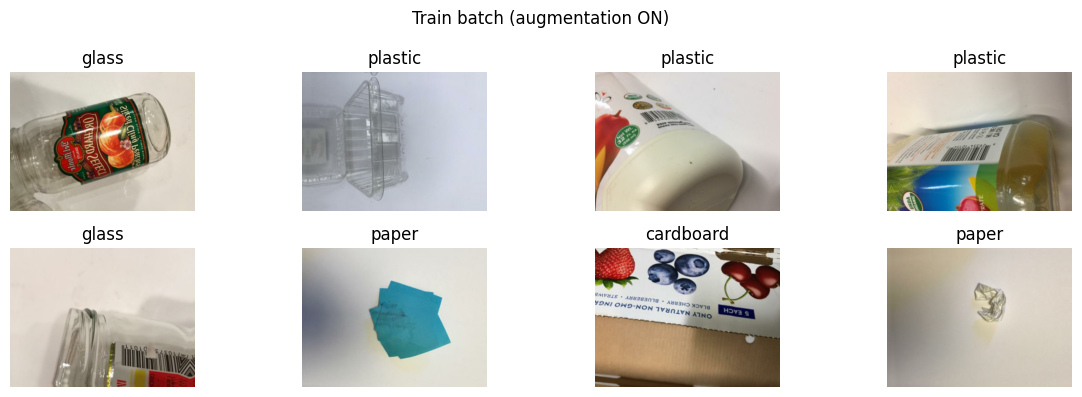

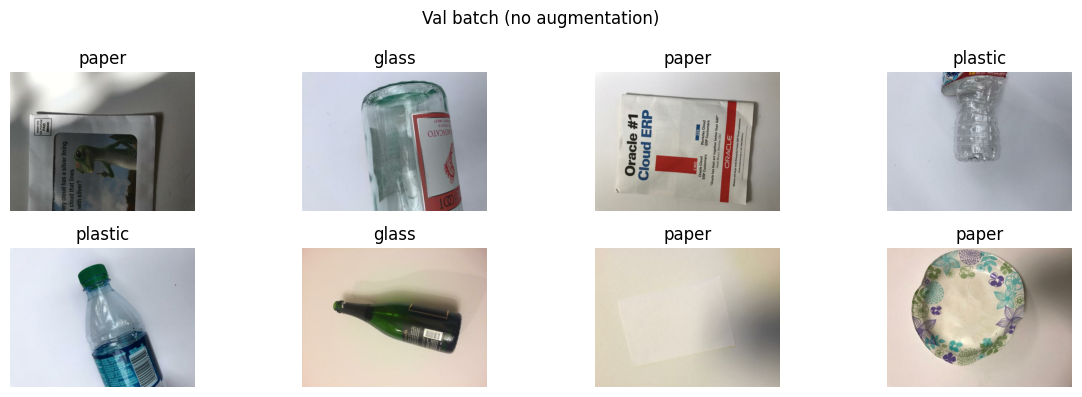

In [9]:
import matplotlib.pyplot as plt

def show_batch(ds, title, n=8):
    x, y = next(iter(ds))
    plt.figure(figsize=(12, 4))
    for i in range(min(n, x.shape[0])):
        ax = plt.subplot(2, n//2, i+1)
        plt.imshow(x[i].numpy())
        plt.title(id2label[int(y[i].numpy())])
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_batch(train_ds, "Train batch (augmentation ON)")
show_batch(val_ds,   "Val batch (no augmentation)")


Questa è la pipeline dati che può essere riusata nei notebook di training (adattando il formato per il modello che stiamo addetrando).
Sarà sostanzialmente uguale per CNN che lavora con tensori ma modificheremo per Logistic Regression.

Nei notebook dei modelli basta:
1. importare da `src`
2. caricare `df` dal DB
3. creare `train_ds/val_ds/test_ds`
4. definire e allenare il modello (`model.fit`)
